In [2]:
#imports and config

import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "courier"
    }
)

In [3]:
#put helper functions/calculations here!

def con(x):
    """Convert to float if possible"""
    try:
        return float(x)
    except:
        return None

def adjust_typing(data):
    data = data.convert_dtypes()
    data["Plx"] = data["Plx"].apply(con)
    data["e_Plx"] = data["e_Plx"].apply(con)
    data["B-V"] = data["B-V"].apply(con)
    data["Vmag"] = data["Vmag"].apply(con)
    data["Hpmag"] = data["Hpmag"].apply(con)
    data["_Glon"] = data["_Glon"].apply(con)
    data["_Glat"] = data["_Glat"].apply(con) 
    return data

#parallax is given in milliarcseconds (mas). Following is an ordered list (same order as columns) of units:
#deg|deg|deg|deg|deg|deg|deg|deg|d|s| | | | |mag| | |deg|deg| |mas|mas/yr|mas/yr|mas|mas|mas|mas/yr|mas/yr| | | | | | | | | | |%| |mag|mag|mag|mag| |mag|mag| |mag|mag| | |mag|mag|mag| | |mag|mag|d| | | | | | | | | | | |deg|arcsec|arcsec|mag|mag| | | | | | | |mag| | | | |deg|deg
def add_dist_cols(data):
    """Adds columns related to distance, i.e. distance, standard distance error both negative and positive
        Since the standard error on the parallax does not give the same standard error for distance for both the + and -, we take both.
        Dist = 1/tan(x/1000) (x in milliarcseconds)
        e_Dist* = 1/tan((x+/-e_x)/1000) - dist
    """
    mas_to_pc = lambda x : 1/(np.tan(x/1000))
    data["Dist"] = abs(mas_to_pc(data["Plx"])) #convert mas to parsecs
    data["e_Dist_pos"] = mas_to_pc(data["Plx"]-data["e_Plx"]) - data["Dist"]
    data["e_Dist_neg"] = mas_to_pc(data["Plx"]+data["e_Plx"]) - data["Dist"]
    return data

def add_color_by_bv(data):
    data["Temp"] = 4600*(1/(0.92*data["B-V"]+1.7)+1/(0.92*data["B-V"]+0.62))
    return data

def add_mag(data):
    absmag_calc = lambda m, d : m-5*np.log10(d/10)
    data["absmag"] = absmag_calc(data["Hpmag"],data["Dist"])
    return data

#get all stars that are within 50pc (include stars where Dist-|e_Dist_neg| < 50, i.e. where the standard error makes it possible for the star to be within 50 pc)
def get_close_stars(data, dist, ρ):
    """Takes the data, a distance (in parsecs), and ρ (a percent as a decimal error in distance), and returns a subset of the initial dataframe."""
    return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


#----APPLY ABOVE TO DATA-----
def run_all_preproc(data, get_close = True):
    data = adjust_typing(data)
    data = add_dist_cols(data)
    data = add_color_by_bv(data)
    data = add_mag(data)

    #filter functions:
    if get_close:
        data = get_close_stars(data, 50, 0.05)
    return data

In [4]:
data = pd.read_csv("Vizier/hip_full_formatted2.csv", sep=",", low_memory=False)
data

_Glon     _Glat   _RAJ2000     _DEJ2000   _RAB1950     _DEB1950  \
0       111.3597   -36.417  2.5542817   25.5267532  1.9084505   25.2485924   
1       117.8018   -2.4347  2.5587584   60.0260469  1.8993345   59.7479435   
2        116.328  -11.4583  2.5680176   50.8848982  1.9129509   50.6066901   
3       116.5543  -10.1061  2.5685944   52.2551367  1.9137442   51.9770508   
4       307.7633  -45.9035  2.5746672  -70.8368948  1.9654422   -71.115109   
...          ...       ...        ...          ...        ...          ...   
118213  305.5981  -38.6129  2.5334041   -78.300717  1.9452866  -78.5786775   
118214  320.0866  -66.5871  2.5389894  -49.1433742   1.909107  -49.4212892   
118215   355.806  -79.1764  2.5423143  -33.2810479  1.9084617  -33.5587074   
118216   67.8416  -78.1572  2.5433657  -19.9835787  1.9063664  -20.2616779   
118217  118.5312    2.1281  2.5436028    64.646715   1.881335   64.3686568   

          _Elon2000    _Elat2000           _time  _etime  ...          BD  \
0        13.0113022   22.2950371                       0  ...  B+24    7    
1         36.181116   51.8039073                       0  ...  B+59    4    
2        27.9612575   44.4761435                       0  ...  B+50   14    
3        29.0524755   45.6089037                       0  ...  B+51   12    
4       312.1564164  -60.7514104                       0  ...               
...             ...          ...             ...     ...  ...         ...   
118213  297.9814094  -64.4204886                       0  ...               
118214  337.2332878  -44.8670259                       0  ...               
118215  347.5585568  -31.2126153                       0  ...               
118216  354.0603912  -19.2772135                       0  ...  B-20    9    
118217   41.3822498   55.2408034                       0  ...  B+63    5    

               CoD         CPD (V-I)red        SpType r_SpType  HIPep  \
0                                  0.42  F0III               X  HIPep   
1                                  1.23  G8III               X  HIPep   
2                                  1.08  K0                  S  HIPep   
3                                 -0.03  B9                  S  HIPep   
4                   P-71     2     0.48  F2/F3V              1  HIPep   
...            ...         ...      ...           ...      ...    ...   
118213              P-78     4     1.33  K3III               1  HIPep   
118214  C-49    20  P-49    15     0.56  F5V                 2  HIPep   
118215  C-33    26  P-33    10     0.83  G8V                 3  HIPep   
118216                             0.60  F7V                 4  HIPep   
118217                             1.02  K0                  S  HIPep   

        Erratum    _RA.icrs   _DE.icrs  
0       Erratum  2.55428171  25.526753  
1       Erratum   2.5587584  60.026047  
2       Erratum  2.56801765  50.884898  
3       Erratum  2.56859443  52.255137  
4       Erratum   2.5746672 -70.836895  
...         ...         ...        ...  
118213  Erratum  2.53340406 -78.300717  
118214  Erratum  2.53898941 -49.143374  
118215  Erratum  2.54231429 -33.281048  
118216  Erratum   2.5433657 -19.983579  
118217  Erratum  2.54360277  64.646715  

[118218 rows x 90 columns]

In [5]:
good_stuff = run_all_preproc(data.copy(deep=True))
data = run_all_preproc(data,False)

C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\3888758096.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


In [6]:
good_stuff

_Glon    _Glat   _RAJ2000     _DEJ2000   _RAB1950     _DEB1950  \
75       82.2291 -75.0646  2.8160718  -15.4679774   2.179996  -15.7424089   
84      112.7888 -31.6319  2.8434915    30.449575  2.1922705   30.1709904   
100     313.2897 -58.8474  2.8991422   -57.472549   2.274755   -57.749824   
115     347.1573 -78.3386  2.9333693  -35.1331196  2.2988017  -35.4128739   
139     112.2310 -34.9531  3.0167662   27.0989536  2.3650203   26.8220369   
...          ...      ...        ...          ...        ...          ...   
118071  108.5536 -44.2440  2.1136653   17.4242998  1.4716207   17.1469363   
118083  113.4434 -25.4553  2.1705757   36.6271251  1.5252334   36.3506461   
118129  117.5269  -3.2772  2.2945211   59.1497796  1.6238581    58.874119   
118142  108.8699 -44.1846  2.3310181   17.5339216  1.6872154   17.2575215   
118148  324.3387 -69.5948  2.3526749  -45.7474262  1.7197547  -46.0232252   

          _Elon2000    _Elat2000           _time  _etime  ...  r_SpType  \
75      356.2766277  -15.2794553                       0  ...         4   
84       15.6260988   26.6122458                       0  ...         X   
100     329.9694737  -51.6632046                       0  ...         1   
115     346.8699635  -32.9999548                       0  ...         3   
139      14.1536636   23.5346266                       0  ...         S   
...             ...          ...             ...     ...  ...       ...   
118071    9.0225413   15.1138691                       0  ...         S   
118083   18.2987533   32.3631432                       0  ...         S   
118129   35.1166472   51.2149733                       0  ...         X   
118142    9.2649998   15.1284086                       0  ...         X   
118148  339.6480342    -41.95603                       0  ...         X   

        HIPep  Erratum    _RA.icrs   _DE.icrs       Dist e_Dist_pos  \
75      HIPep  Erratum  2.81607181 -15.467977  18.871659   0.279052   
84      HIPep  Erratum  2.84349154  30.449575  34.061766   1.140034   
100     HIPep  Erratum  2.89914223 -57.472549  36.407452   1.505638   
115     HIPep  Erratum  2.93336928  -35.13312  21.794965   0.318759   
139     HIPep  Erratum  3.01676621  27.098954  25.707203   0.833614   
...       ...      ...         ...        ...        ...        ...   
118071  HIPep  Erratum  2.11366527    17.4243  21.895389   0.962863   
118083  HIPep  Erratum   2.1705757  36.627125  33.036839   0.771362   
118129  HIPep  Erratum  2.29452113   59.14978  16.677310   0.157788   
118142  HIPep  Erratum  2.33101814  17.533922  51.860793   2.216332   
118148  HIPep  Erratum  2.35267495 -45.747426  42.947566   1.888050   

       e_Dist_neg         Temp    absmag  
75      -0.271059  6448.441919  3.623450  
84      -1.068567  5420.152135  5.425164  
100     -1.390700  5020.665377  6.373449  
115     -0.309718  6580.881646  3.650719  
139     -0.782916  4637.228591  6.822926  
...           ...          ...       ...  
118071  -0.885173  3854.680056  9.176637  
118083  -0.736979  6370.803054  3.722608  
118129  -0.154868  6988.564782  1.247270  
118142  -2.041873  5800.437593  3.624804  
118148  -1.735538  4711.740844  0.880507  

[4778 rows x 95 columns]

In [7]:
#Begin Analysis

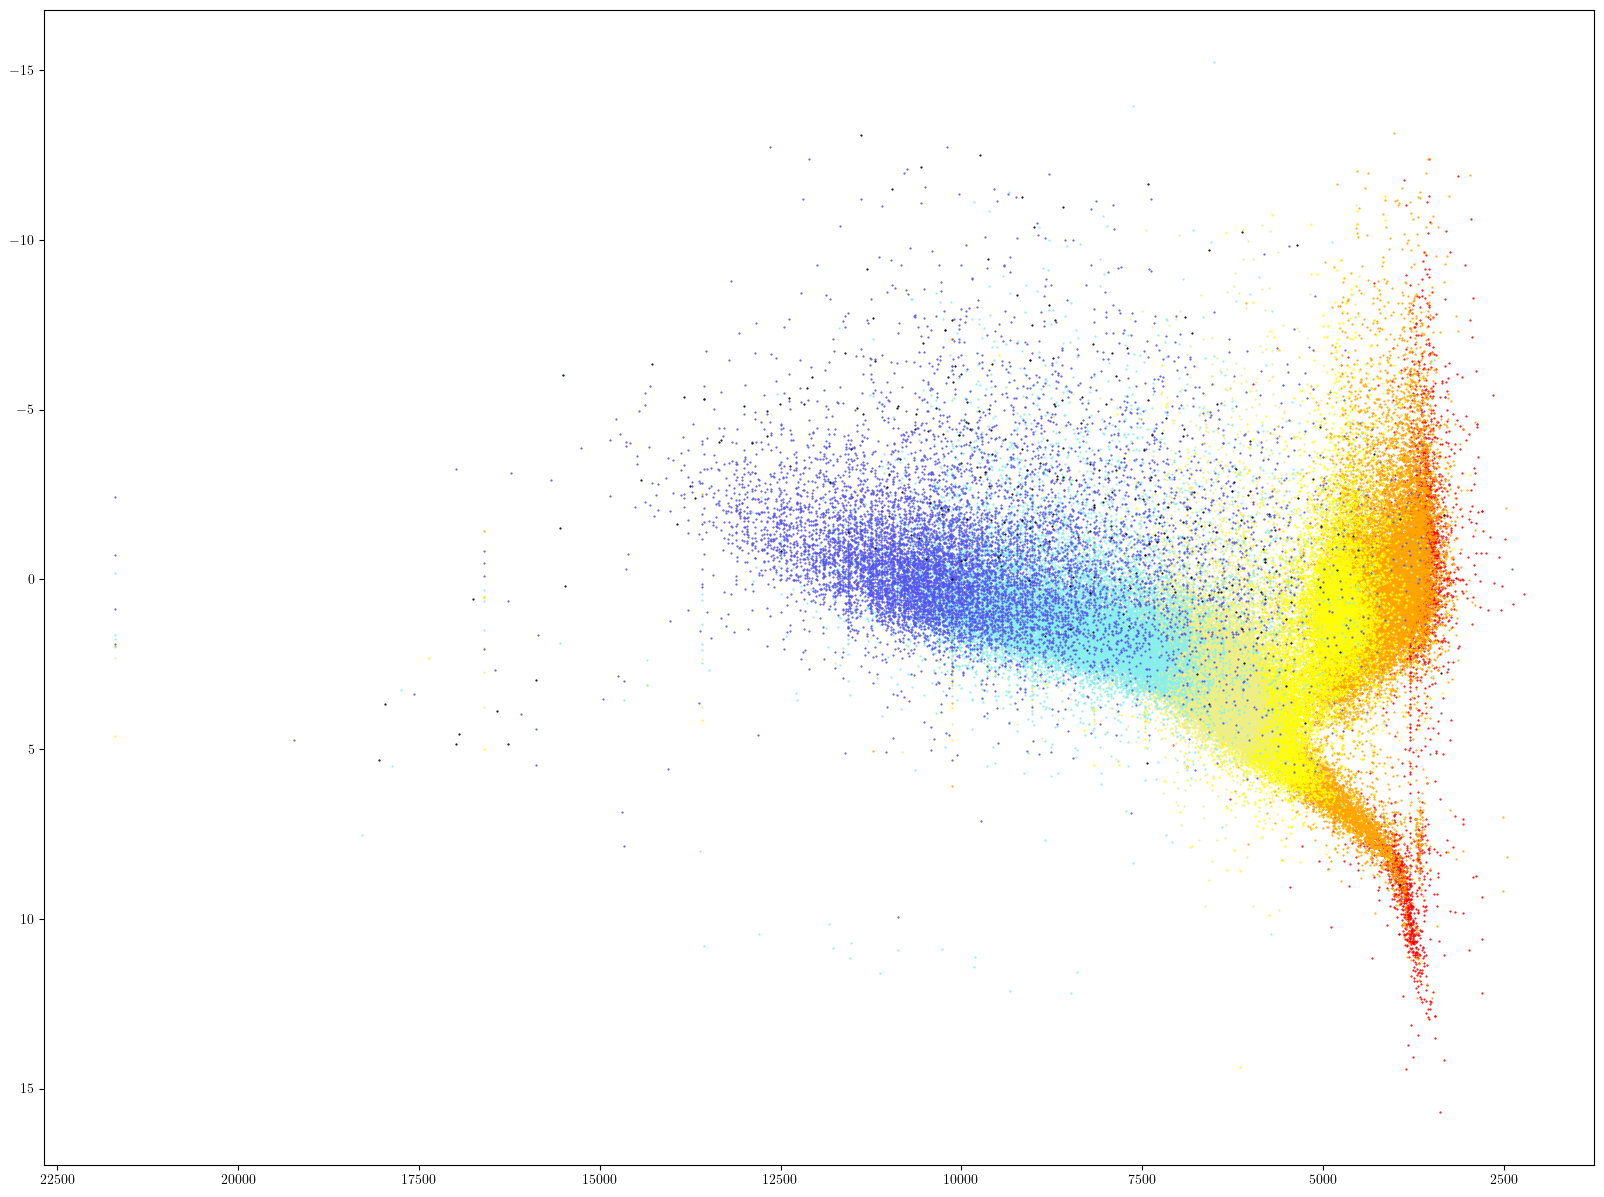

In [8]:


data_of_spec = lambda data, type_ : data[data["SpType"].str.contains(type_)]
scatter_spect = lambda data, type_, color : plt.scatter(data_of_spec(data,type_)["Temp"],data_of_spec(data,type_)["absmag"],s=.3,color = color, label = type_)
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
plt.figure(figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)
scatter_spect(data, "M", "red") # plt.scatter (x=data[data["SpType"].str.contains("M")]["Temp"], y=data[data["SpType"].str.contains("M")]["absmag"], s=.3, color=red, label="M")
scatter_spect(data, "K", "orange")
scatter_spect(data, "G", "yellow")
scatter_spect(data, "F", "#EEEE88")
scatter_spect(data, "A", "#88EEEE")
scatter_spect(data, "B", "#5555EE")
scatter_spect(data, "O", "black")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

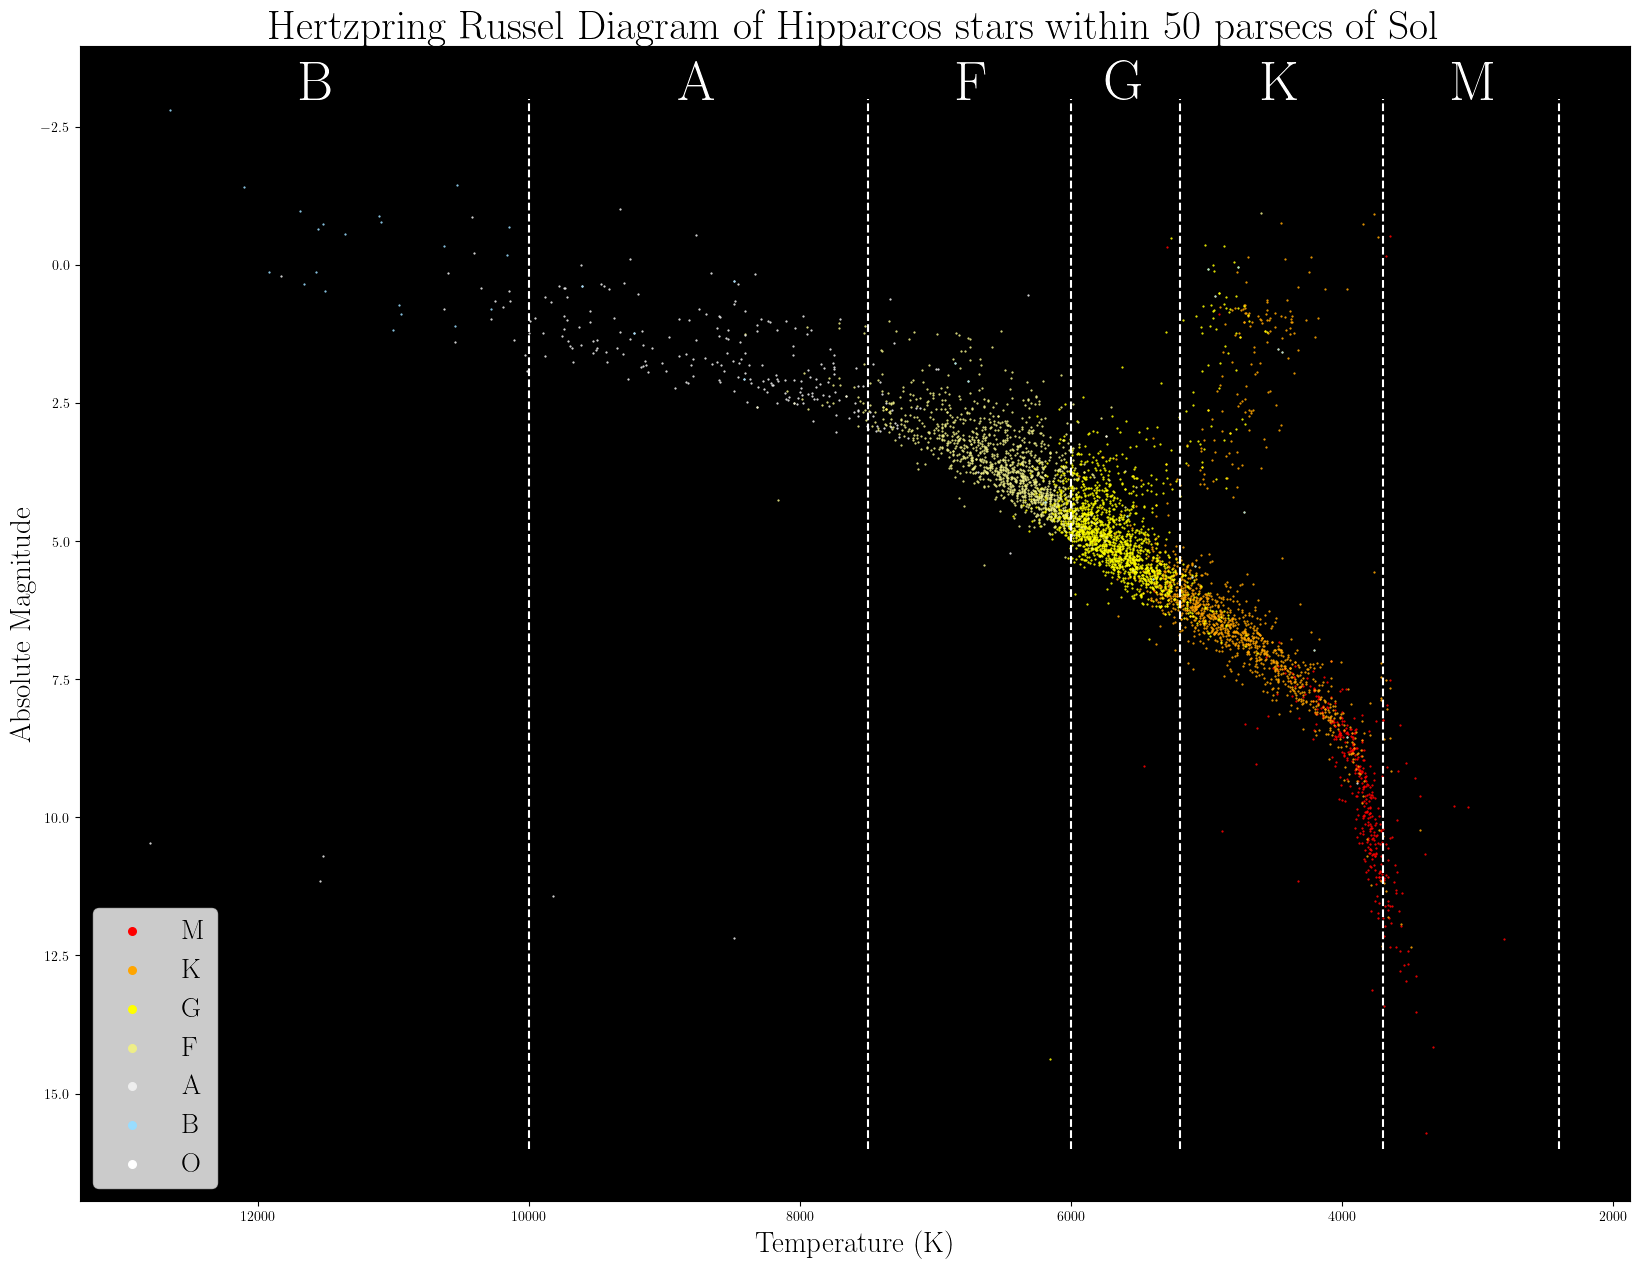

In [140]:
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
vert = lambda x,y0,y1 : ax.plot([x,x],[y0,y1], '--w') 
fig,ax = plt.subplots(1,1, figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)

vert(2400,16,-3)
ax.text(3200,-3, "M", fontsize=40, color = "white" )
vert(3700,16,-3)
ax.text(4600,-3, "K", fontsize=40, color = "white" )
vert(5200,16,-3)
ax.text(5750,-3, "G", fontsize=40, color = "white" )
vert(6000,16,-3)
ax.text(6850,-3, "F", fontsize=40, color = "white" )
vert(7500,16,-3)
ax.text(8900,-3, "A", fontsize=40, color = "white" )
vert(10000,16,-3)
ax.text(11700,-3, "B", fontsize=40, color = "white" )
#vert(30000,16,-3)


M = scatter_spect(good_stuff, "M", "red")
K = scatter_spect(good_stuff, "K", "orange")
G = scatter_spect(good_stuff, "G", "yellow")
F = scatter_spect(good_stuff, "F", "#EEEE88")
A = scatter_spect(good_stuff, "A", "#EEEEEE")
B = scatter_spect(good_stuff, "B", "#99DDFF")
O = scatter_spect(good_stuff, "O", "white")

ax.set_title("Hertzpring Russel Diagram of Hipparcos stars within 50 parsecs of Sol",fontsize = 30)
ax.set_xlabel("Temperature (K)", fontsize = 21)
ax.set_ylabel("Absolute Magnitude", rotation = 90, fontsize = 21)
ax.legend(fontsize = 20,markerscale = 10)
ax.set_facecolor('black')
fig.set_facecolor('white')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig("Completeness/figures/hr-diagram.png")
plt.show()

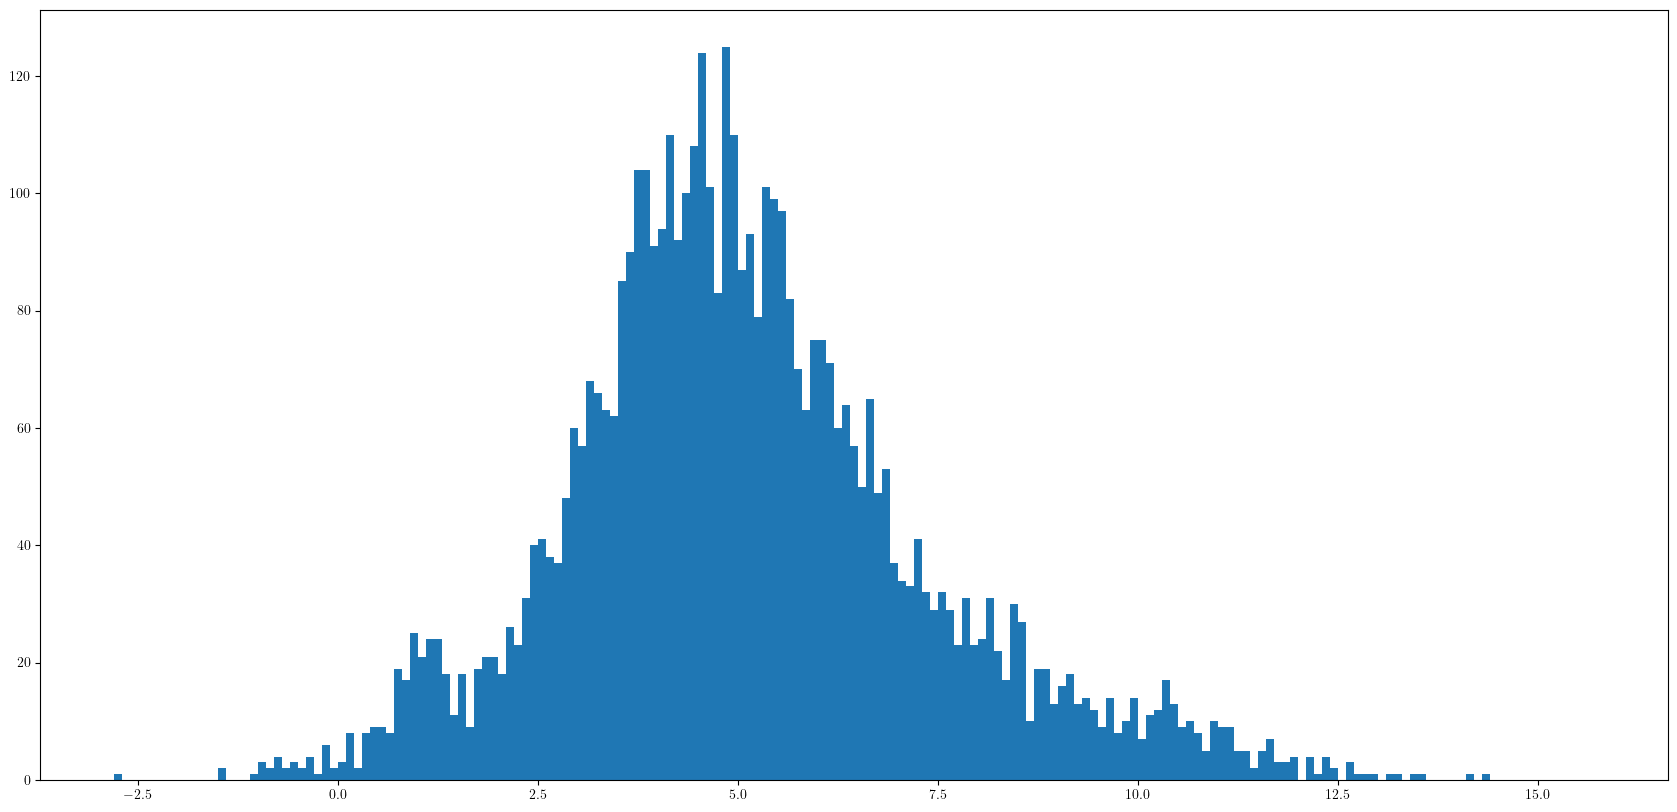

In [10]:
plt.figure(figsize=(21,10))
plt.hist(good_stuff["absmag"], bins=np.arange(min(good_stuff["absmag"]),max(good_stuff["absmag"]),.1))
plt.savefig("amag_hist.png")
plt.show()

In [11]:
redco = [ 1.62098281e-82, -5.03110845e-77, 6.66758278e-72, -4.71441850e-67, 1.66429493e-62, -1.50701672e-59, -2.42533006e-53, 8.42586475e-49, 7.94816523e-45, -1.68655179e-39, 7.25404556e-35, -1.85559350e-30, 3.23793430e-26, -4.00670131e-22, 3.53445102e-18, -2.19200432e-14, 9.27939743e-11, -2.56131914e-07,  4.29917840e-04, -3.88866019e-01, 3.97307766e+02]
greenco = [ 1.21775217e-82, -3.79265302e-77, 5.04300808e-72, -3.57741292e-67, 1.26763387e-62, -1.28724846e-59, -1.84618419e-53, 6.43113038e-49, 6.05135293e-45, -1.28642374e-39, 5.52273817e-35, -1.40682723e-30, 2.43659251e-26, -2.97762151e-22, 2.57295370e-18, -1.54137817e-14, 6.14141996e-11, -1.50922703e-07,  1.90667190e-04, -1.23973583e-02,-1.33464366e+01]
blueco = [ 2.17374683e-82, -6.82574350e-77, 9.17262316e-72, -6.60390151e-67, 2.40324203e-62, -5.77694976e-59, -3.42234361e-53, 1.26662864e-48, 8.75794575e-45, -2.45089758e-39, 1.10698770e-34, -2.95752654e-30, 5.41656027e-26, -7.10396545e-22, 6.74083578e-18, -4.59335728e-14, 2.20051751e-10, -7.14068799e-07,  1.46622559e-03, -1.60740964e+00, 6.85200095e+02]

redco = np.poly1d(redco)
greenco = np.poly1d(greenco)
blueco = np.poly1d(blueco)

def temp2rgb(temp):

    red = redco(temp)
    green = greenco(temp)
    blue = blueco(temp)
    red = (red/max(red))
    green = (green/max(green))
    
    blue = (blue/max(blue))
    if (min(blue) < 0):
        blue += abs(min(blue))
        blue = (blue/max(blue))

    color = []
    for r,g,b in zip(red,green,blue):
        color.append([r,
                     g,
                     b])

    return color

C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1552844296.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1552844296.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1552844296.py:10: UserWarning: Boolean Series key will be reindexed to mat

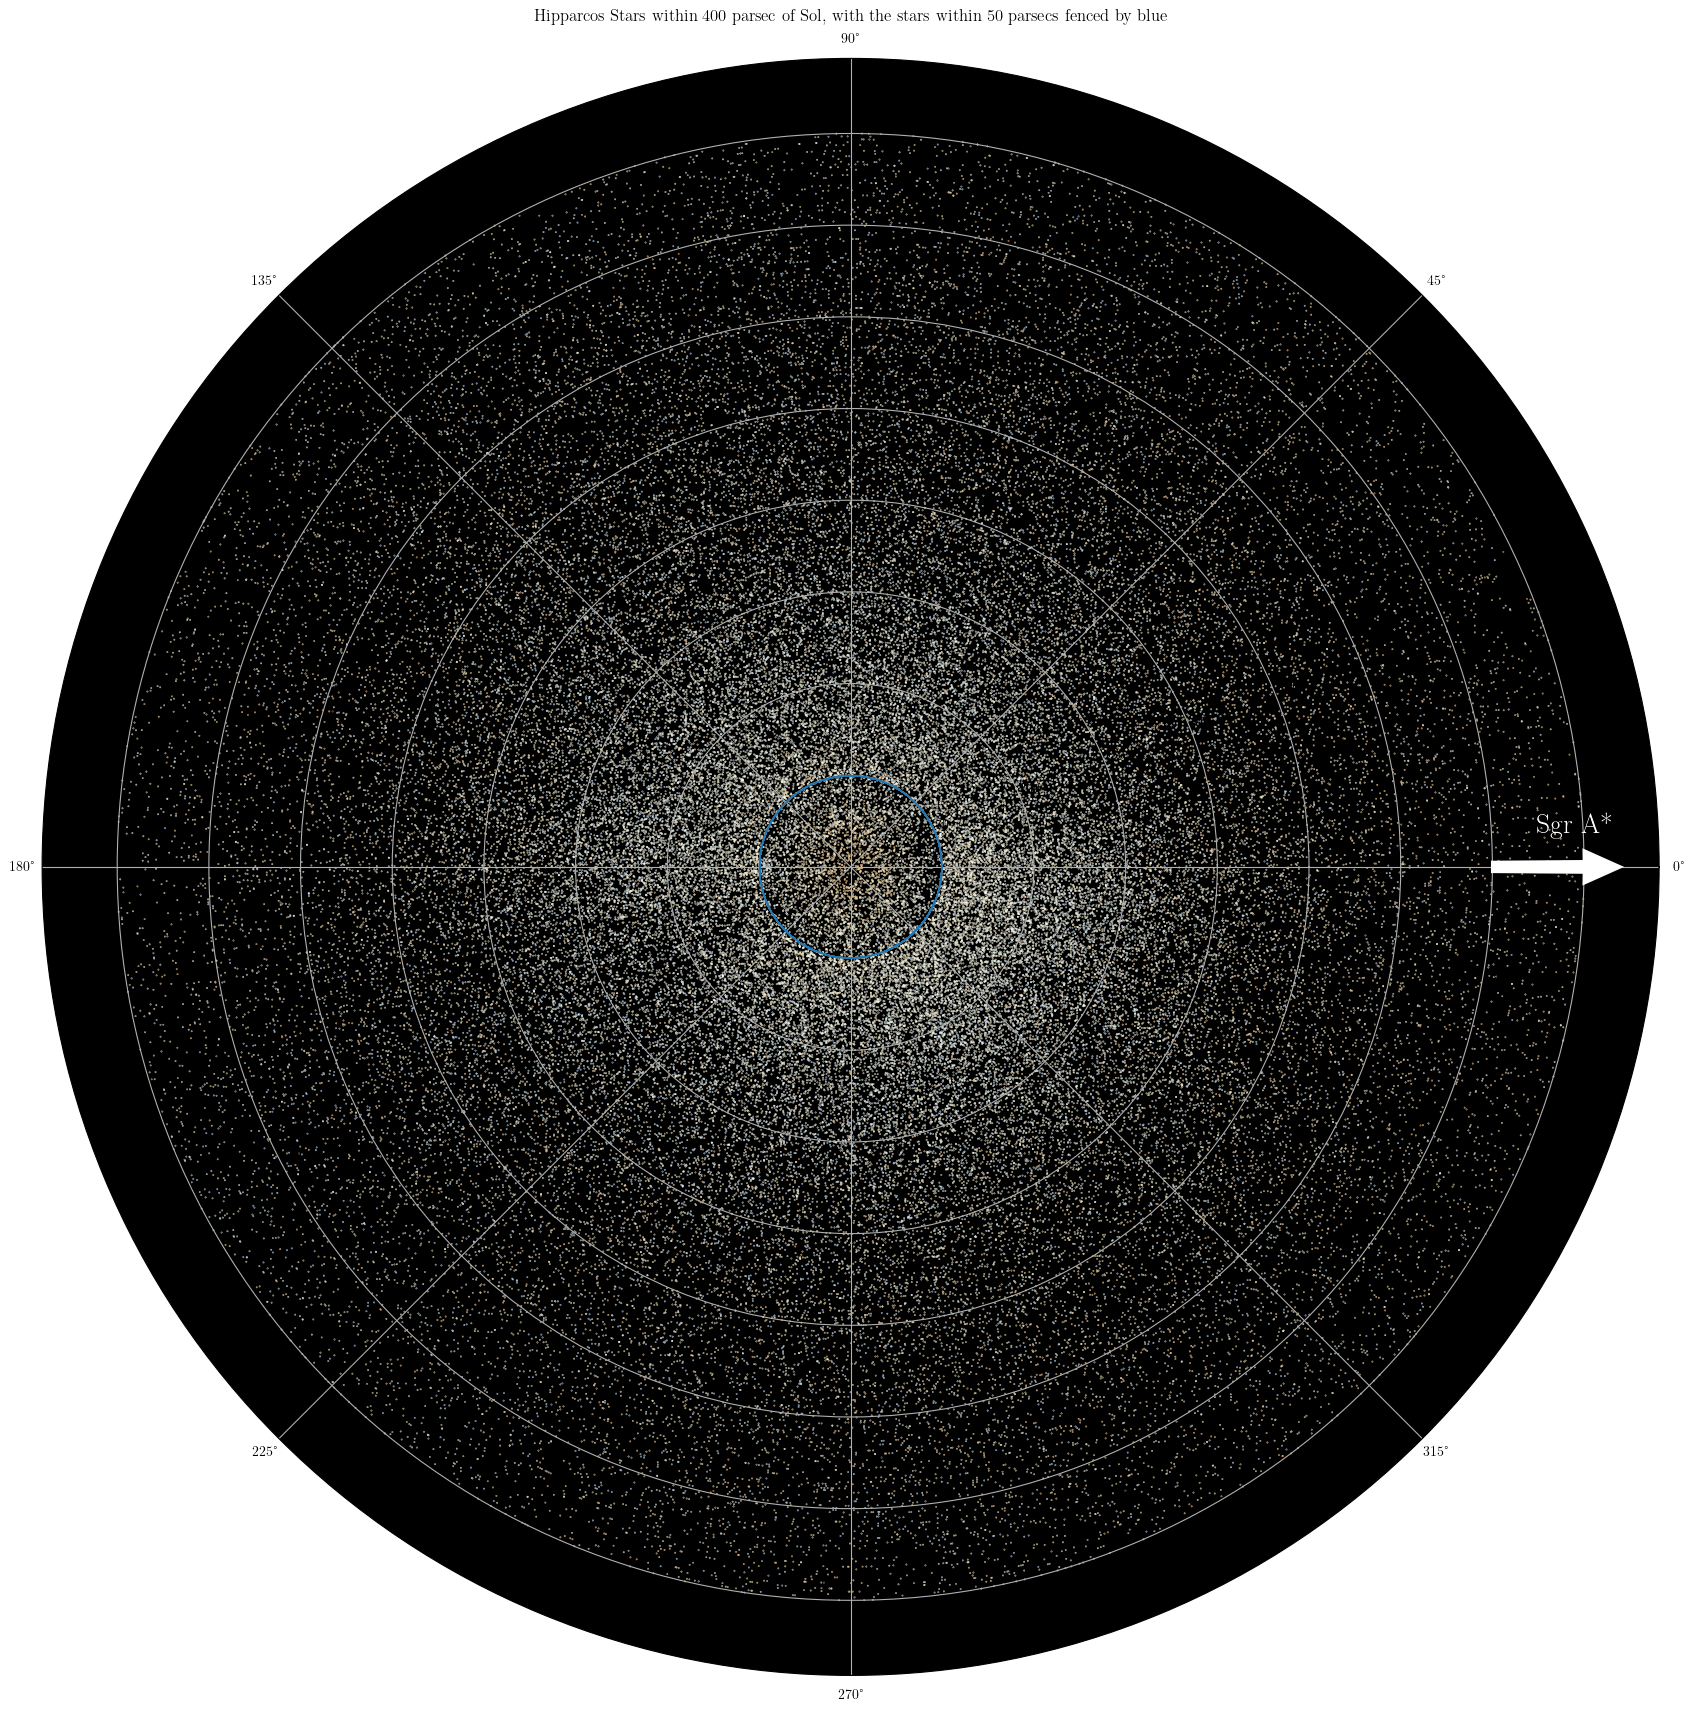

In [12]:
fig, ax = plt.subplots(1,1, figsize=(21,21),subplot_kw={'projection': 'polar'})

r = np.ones(1000)*50
theta = np.linspace(0,2 * np.pi * 50,1000)

data_max = 400
data_min = 51

ax.scatter(good_stuff.sort_values("_Glon")["_Glon"]*np.pi/180, good_stuff.sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(good_stuff.sort_values("_Glon")["Temp"]))
ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))
ax.plot(theta, r, lw=0.1)
ax.arrow(0,350,0,50, color="white", width=0.015, head_length=20, lw = 2, zorder=5)
ax.text(np.pi/64,375,"Sgr A*", color = "white", fontsize = 20, fontweight = "bold")
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Hipparcos Stars within 400 parsec of Sol, with the stars within 50 parsecs fenced by blue", va='bottom')
ax.set_facecolor('black')
plt.savefig("galactic_map.png")
plt.show()

In [214]:
from scipy.stats import skewnorm
import random as rand 
#stat constants

pi = 3.141592
e = 2.718281


#stat helper functions

mean = lambda data : sum(data)/len(data)
rms = lambda data : np.sqrt(mean(data**2))
def build_hists(ax, fdata, filter,title, label, colors=["blue", "green"], hist_aspect=50, hist_max=4000):
    hist_min, hist_max = (min(fdata[filter]),hist_max)
    h = ax.hist( fdata[filter], bins=np.arange(hist_min,hist_max,hist_aspect), alpha = 0.5, label = label)
    dmean = mean(fdata[filter])
    # print(dmean)
    # print(int(dmean/hist_aspect))
    # print(h)
    hist = np.histogram(fdata[filter], bins=np.arange(hist_min,hist_max,hist_aspect))
    ax.axvline(dmean, color = colors[0], label = f"{label} mean = {dmean:.2f}" )
    dmedian = np.median(fdata[filter])
    ax.axvline(dmedian, color = colors[1], label = f"{label} median = {dmedian:.2f}")
    dsig = np.sqrt(variance(fdata[filter]))
    ax.axvline(dsig, color = colors[1], label = f"{label} stdvar = {dsig:.2f}")
    #ax.scatter(dmean,h[0][int(dmean/hist_aspect)], color = "black") 
    ax.set_title(title)
    return hist 


def variance(fdata):
    sm = mean(fdata)**2
    ms = mean(fdata**2)
    return (ms-sm)

def plot_dist(ax, data , m, var):
    shape, loc, scale = skewnorm.fit(data)
    print(shape, scale)
    x = data
    y = (shape/scale)*(x/scale)**(shape-1) * e**(-(x/scale)**shape)
    print(y)
    ax.scatter(x,y*700000)
    return x, y

def z_score(data):
    return (data-mean(data))/(variance(data)**0.5)

def t_test(population, sample_size):
    mu = mean(population)
    sig = np.sqrt(variance(population))
    t = np.array([(X-mu)/(sig/np.sqrt(sample_size)) for X in [mean(np.random.choice(population, sample_size)) for i in range(0,1000)]])
    return t

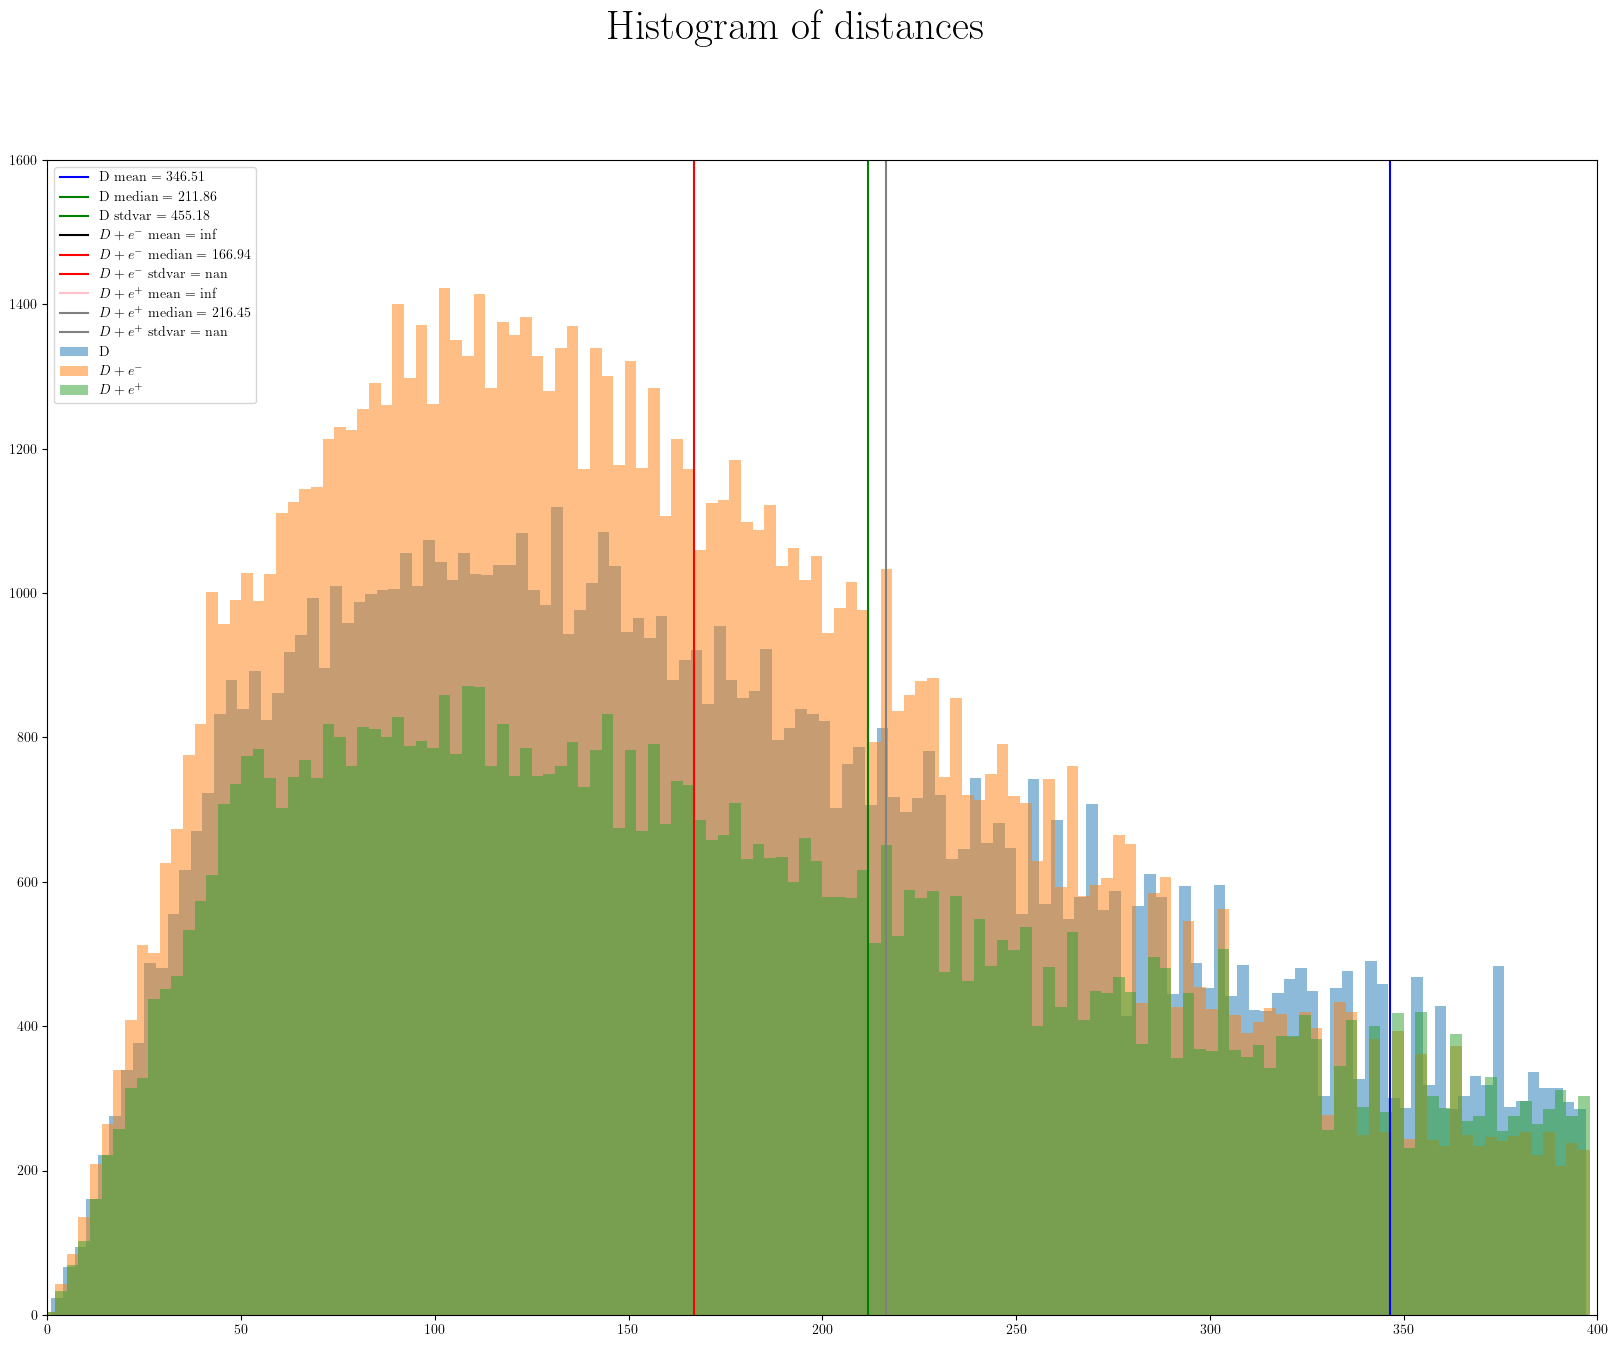

In [215]:
#null hypothesis: the distribution of stars close to Sol is uniform and thus the number of stars at a given distance away from Sol should be proportional to that distance (i.e. linear)
#alternative hypothesis: the distribution of stars - in general - is not uniform close to Sol

fig,ax1 = plt.subplots(1,1, figsize=(20,15))
fig.suptitle("Histogram of distances", fontsize = 30)

quads = [2.5,5,7.5]
ax1_data = data[data["Dist"]<4000]
ax1_data2 = ax1_data.copy(deep=True)
ax1_data2["Dist"] = ax1_data["Dist"] + ax1_data["e_Dist_neg"] 
ax1_data3 = ax1_data.copy(deep=True)
ax1_data3["Dist"] = ax1_data["Dist"] + ax1_data["e_Dist_pos"] 
build_hists(ax1, ax1_data, "Dist", "","D", ["blue", "green"],3, 400)
build_hists(ax1, ax1_data2, "Dist","", r"$D+e^-$", ["black", "red"],3, 400)
build_hists(ax1, ax1_data3, "Dist","", r"$D+e^+$", ["pink", "gray"],3, 400)
ax1.set_ylim(bottom = 0, top = 1600)
ax1.set_xlim(left = 0, right = 400)
ax1.legend()


plt.savefig("Completeness/figures/dist_hist_base.png")
plt.show()

C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\231512466.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000]
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\231512466.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\231512466.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]


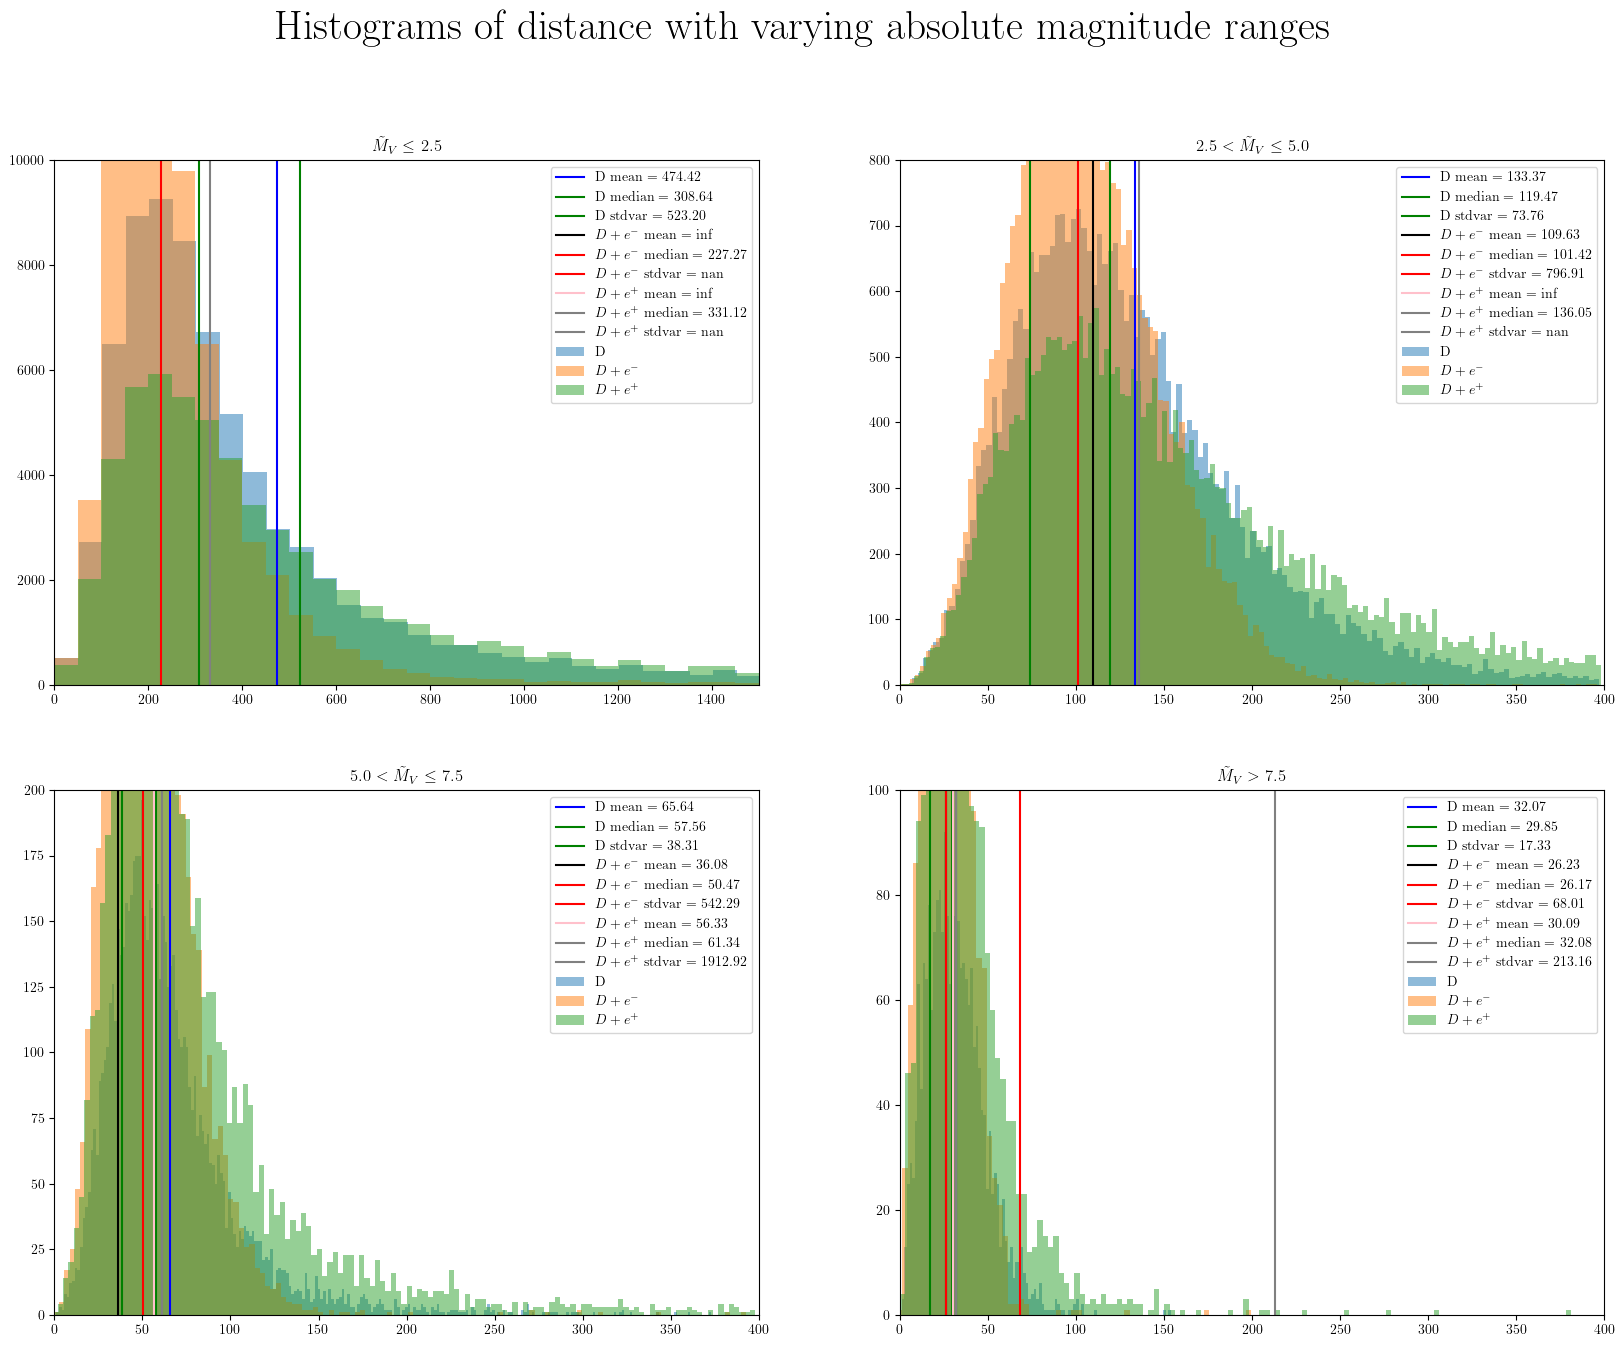

In [216]:

fig,ax = plt.subplots(2,2, figsize=(20,15))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
fig.suptitle("Histograms of distance with varying absolute magnitude ranges", fontsize = 30)

quads = [2.5,5,7.5]
ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000]
ax1_data2 = ax1_data.copy(deep=True)
ax1_data2["Dist"] = ax1_data["Dist"] + ax1_data["e_Dist_neg"] 
ax1_data3 = ax1_data.copy(deep=True)
ax1_data3["Dist"] = ax1_data["Dist"] + ax1_data["e_Dist_pos"] 
build_hists(ax1, ax1_data, "Dist", r"$\tilde{M}_V \le$ %.1f"%(quads[0]),"D")
build_hists(ax1, ax1_data2, "Dist",r"$\tilde{M}_V \le$ %.1f"%(quads[0]), r"$D+e^-$", ["black", "red"])
build_hists(ax1, ax1_data3, "Dist",r"$\tilde{M}_V \le$ %.1f"%(quads[0]), r"$D+e^+$", ["pink", "gray"])
ax1.set_ylim(bottom = 0, top = 10000)
ax1.set_xlim(left = 0, right = 1500)
ax1.legend()

ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]
ax2_data2 = ax2_data.copy(deep=True)
ax2_data2["Dist"] = ax2_data["Dist"] + ax2_data["e_Dist_neg"] 
ax2_data3 = ax2_data.copy(deep=True)
ax2_data3["Dist"] = ax2_data["Dist"] + ax2_data["e_Dist_pos"] 
ax2_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1])
h2 = build_hists(ax2, ax2_data, "Dist", ax2_title,"D",["blue", "green"], 3, 400)
h22 = build_hists(ax2, ax2_data2, "Dist", ax2_title, r"$D+e^-$", ["black", "red"], 3, 400)
h23 = build_hists(ax2, ax2_data3, "Dist", ax2_title, r"$D+e^+$", ["pink", "gray"], 3, 400)
ax2.set_ylim(bottom = 0, top = 800)
ax2.set_xlim(left = 0, right = 400)
ax2.legend()

#plot_dist(ax2, h2[0], mean(ax2_data["Dist"]), variance(ax2_data["Dist"]))

ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]
ax3_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2])
ax3_data2 = ax3_data.copy(deep=True)
ax3_data2["Dist"] = ax3_data["Dist"] + ax3_data["e_Dist_neg"] 
ax3_data3 = ax3_data.copy(deep=True)
ax3_data3["Dist"] = ax3_data["Dist"] + ax3_data["e_Dist_pos"] 
build_hists(ax3, ax3_data, "Dist", ax3_title,"D",["blue", "green"], 1.5, 400)
build_hists(ax3, ax3_data2, "Dist", ax3_title, r"$D+e^-$", ["black", "red"], 3, 400)
build_hists(ax3, ax3_data3, "Dist", ax3_title, r"$D+e^+$", ["pink", "gray"], 3, 400)
ax3.set_ylim(bottom = 0, top = 200)
ax3.set_xlim(left = 0, right = 400)
ax3.legend()

ax4_data = data[data["absmag"]>quads[2]]
ax4_title = r"$\tilde{M}_V >$ %.1f"%(quads[2])
ax4_data2 = ax4_data.copy(deep=True)
ax4_data2["Dist"] = ax4_data["Dist"] + ax4_data["e_Dist_neg"] 
ax4_data3 = ax4_data.copy(deep=True)
ax4_data3["Dist"] = ax4_data["Dist"] + ax4_data["e_Dist_pos"] 
build_hists(ax4, ax4_data, "Dist", ax4_title,"D",["blue", "green"], 1.5, 400)
build_hists(ax4, ax4_data2, "Dist", ax4_title, r"$D+e^-$", ["black", "red"], 3, 400)
build_hists(ax4, ax4_data3, "Dist", ax4_title, r"$D+e^+$", ["pink", "gray"], 3, 400)
ax4.set_ylim(bottom = 0, top = 100)
ax4.set_xlim(left = 0, right = 400)
ax4.legend()

plt.savefig("Completeness/figures/dist_hist.png")
plt.show()

# Distribution of stars at varying distances

The basic assumption we make here is that, within a small area of the galaxy, stars will be uniformly distributed. That is, though the density of stars over the entire radius of the galaxy may change, it should be fairly constant within some limited sample space. Therefore, if the hipparcos catalog does not show a number of stars linearly proportional to the distance from Sol, we can conclude an incompleteness or otherwise selection bias of some kind. Our null hypothesis will then be that the number of stars $N_s$ within some window radius $r$ will be $N_s = \pi r^2 \rho$, where $\rho$ is the approximately constant density of stars within that window. For the sake of constructing a simple representation of our null hypothesis, we can think of question, instead of terms of areas within the window, as circumferences. I.e., the number of stars at some distance $r$ will be directly proportional to that distance 

$$H_0: \mu = $$

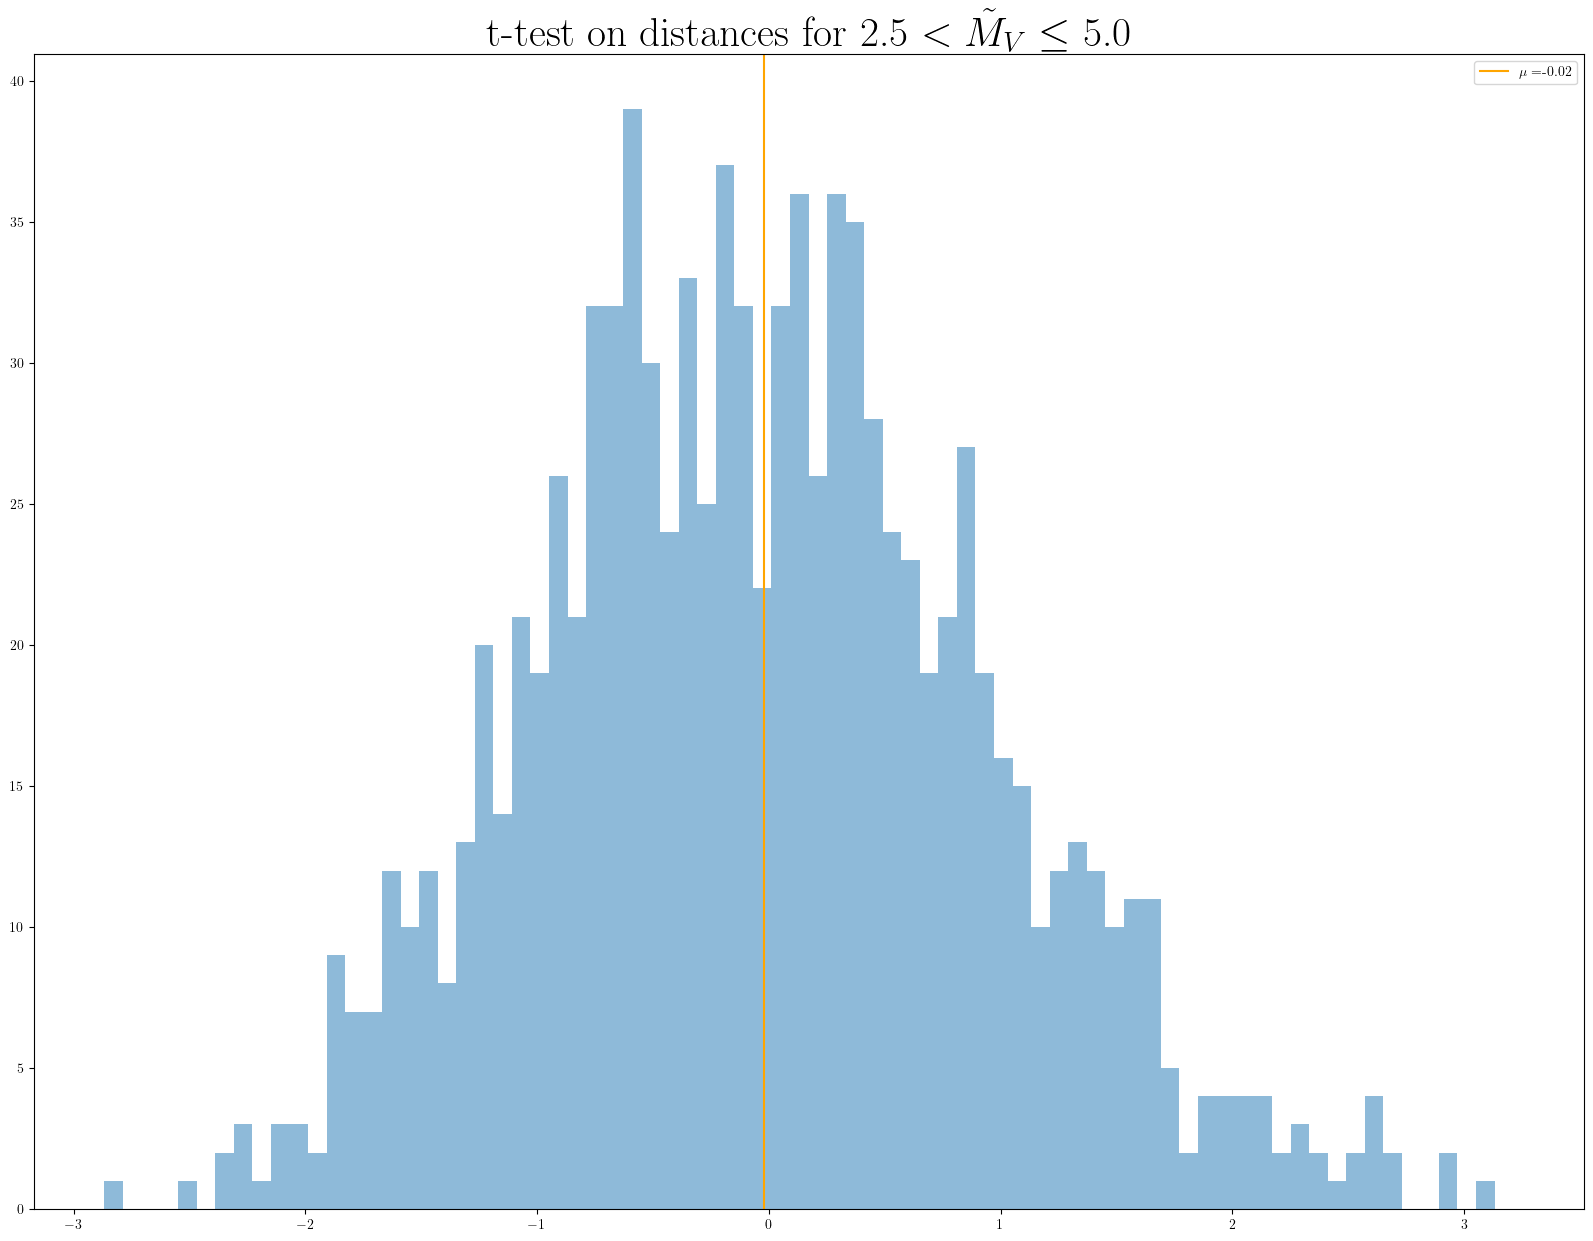

In [217]:
fig,ax = plt.subplots(1,1, figsize=(20,15))
# plt.plot(ax2_data["Dist"],z_score(ax2_data["Dist"]))
# plt.show()
ts = t_test(ax2_data["Dist"], 50)
ax.hist( ts, bins=np.arange(min(ts),max(ts),.08), alpha = 0.5)
smean = mean(ts)

hist = np.histogram(ts, bins=np.arange(min(ts),max(ts),.1))
ax.axvline(smean, color = "orange", label = "$\mu=$%0.2f"%smean)

ax.legend()
ax.set_title("t-test on distances for " + ax2_title, fontsize = 30)
plt.savefig("Completeness/figures/ttest_hist.png")
plt.show()

C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\2567053739.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000]
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\2567053739.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\2567053739.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\2567053739.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Completeness/figures/e_Dist_hist.png")
C:\Users\Fenton\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with larg

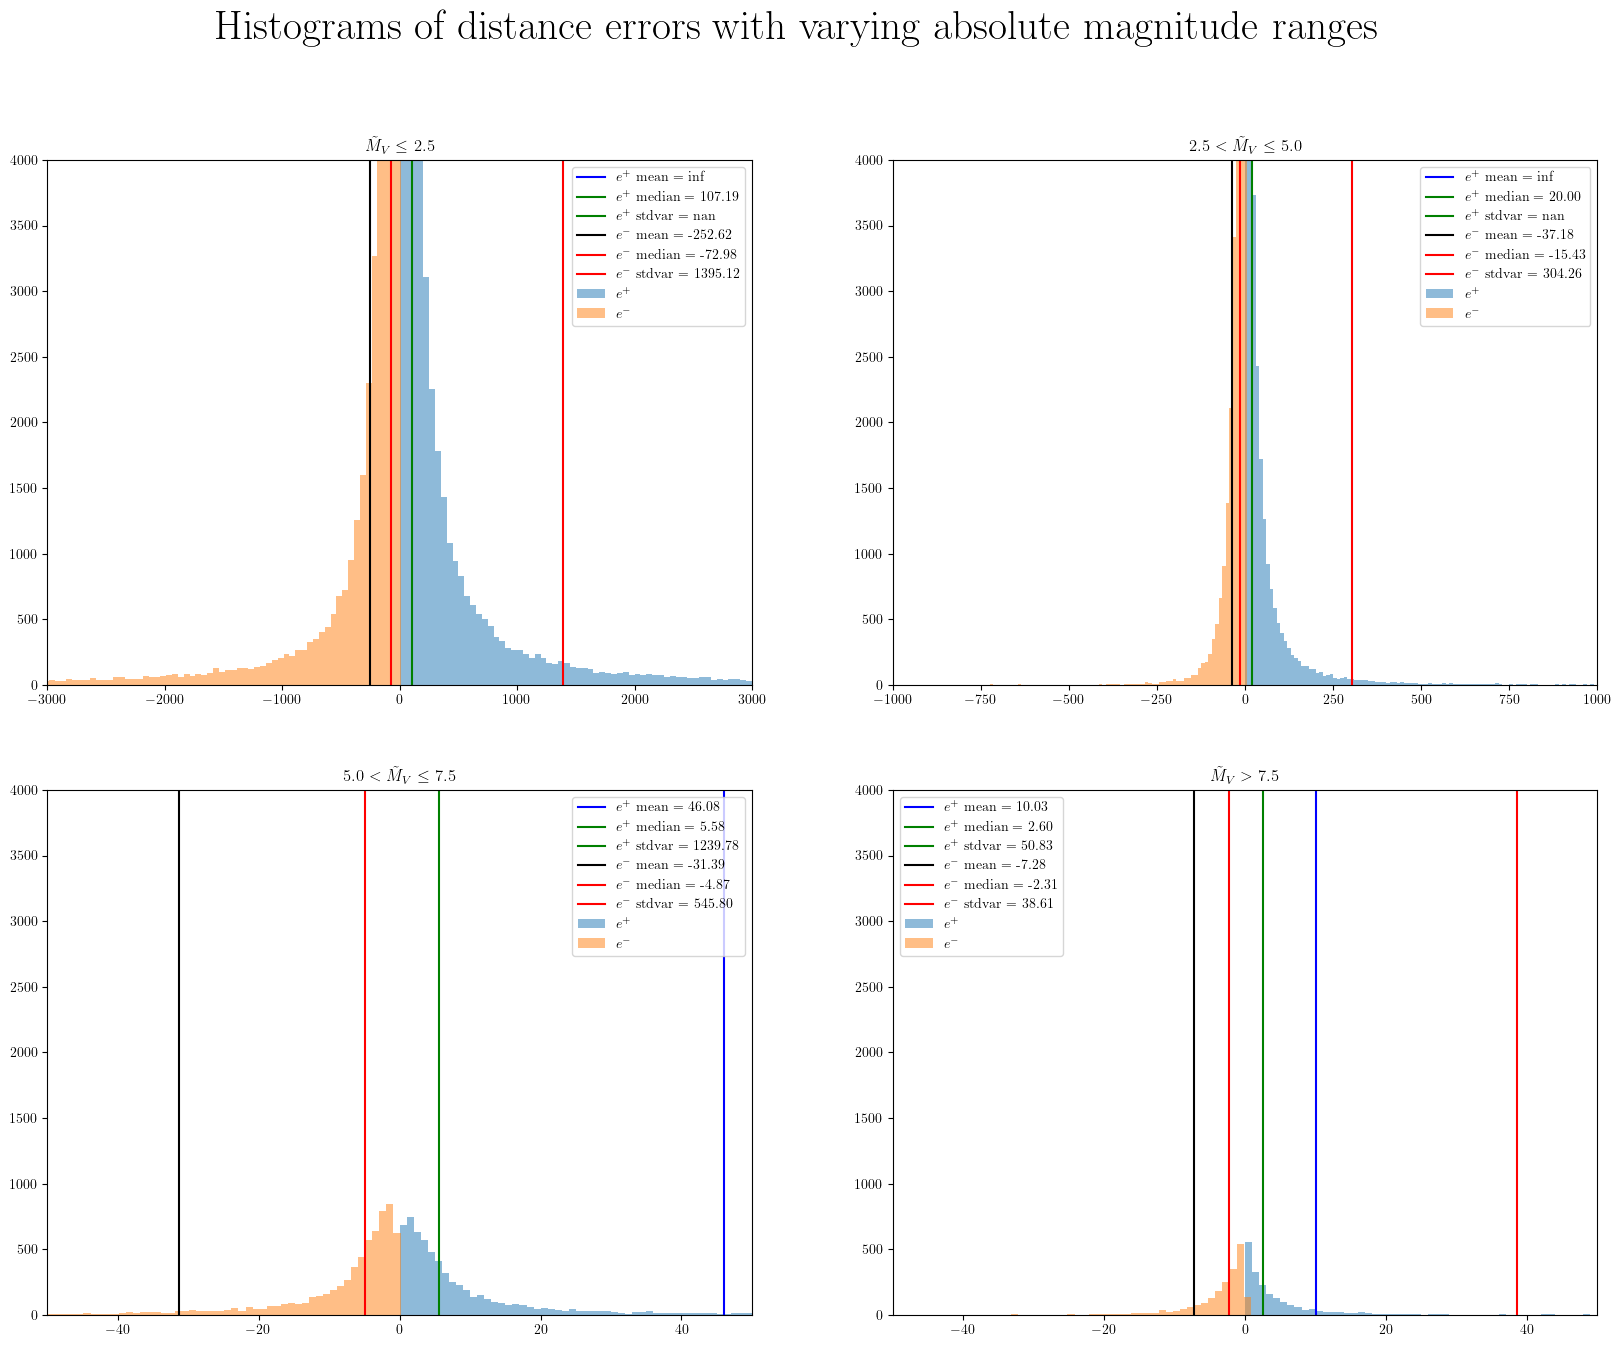

In [218]:
fig,ax = plt.subplots(2,2, figsize=(20,15))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
fig.suptitle("Histograms of distance errors with varying absolute magnitude ranges", fontsize = 30)


hist_min, hist_max = (0,20)
hist_aspect = 0.1


quads = [2.5,5,7.5]
ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000]
ax1_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])
build_hists(ax1, ax1_data[ax1_data["e_Dist_pos"] > 0], "e_Dist_pos", ax1_title,r"$e^+$")
build_hists(ax1, ax1_data[ax1_data["e_Dist_neg"] < 0], "e_Dist_neg",ax1_title, r"$e^-$", ["black", "red"])
ax1.set_ylim(bottom = 0, top = 4000)
ax1.set_xlim(left = -3000, right = 3000)
ax1.legend()

ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]
ax2_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1])
build_hists(ax2, ax2_data[ax2_data["e_Dist_pos"] > 0], "e_Dist_pos", ax2_title,r"$e^+$",["blue", "green"],10)
build_hists(ax2, ax2_data[ax2_data["e_Dist_neg"] < 0], "e_Dist_neg",ax2_title, r"$e^-$", ["black", "red"],10)
ax2.set_ylim(bottom = 0, top = 4000)
ax2.set_xlim(left = -1000, right = 1000)
ax2.legend()

# #plot_dist(ax2, h2[0], mean(ax2_data["Dist"]), variance(ax2_data["Dist"]))

ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]
ax3_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2])
build_hists(ax3, ax3_data[ax3_data["e_Dist_pos"] > 0], "e_Dist_pos", ax3_title,r"$e^+$",["blue", "green"], 1)
build_hists(ax3, ax3_data[ax3_data["e_Dist_neg"] < 0], "e_Dist_neg",ax3_title, r"$e^-$", ["black", "red"], 1)
ax3.set_ylim(bottom = 0, top = 4000)
ax3.set_xlim(left = -50, right = 50)
ax3.legend()

ax4_data = data[data["absmag"]>quads[2]]
ax4_title = r"$\tilde{M}_V >$ %.1f"%(quads[2])
build_hists(ax4, ax4_data[ax4_data["e_Dist_pos"] > 0], "e_Dist_pos", ax4_title,r"$e^+$",["blue", "green"], 1)
build_hists(ax4, ax4_data[ax4_data["e_Dist_neg"] < 0], "e_Dist_neg",ax4_title, r"$e^-$", ["black", "red"], 1)
ax4.set_ylim(bottom = 0, top = 4000)
ax4.set_xlim(left = -50, right = 50)
ax4.legend()

# plt.savefig("Completeness/figures/dist_hist.png")
# plt.show()
# ax1.hist(data[data["absmag"]<=quads[0]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax1_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])

# ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax2_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])
# ax2.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1]))
# ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax3_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2])
# ax3.set_title()
# ax4.hist(data[data["absmag"]>quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax4_title = r"$\tilde{M}_V >$ %.1f"%(quads[2])
plt.savefig("Completeness/figures/e_Dist_hist.png")
plt.show()

C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1780038185.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000].copy(deep=True)
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1780038185.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]].copy(deep=True)
C:\Users\Fenton\AppData\Local\Temp\ipykernel_7932\1780038185.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]].copy(deep=True)


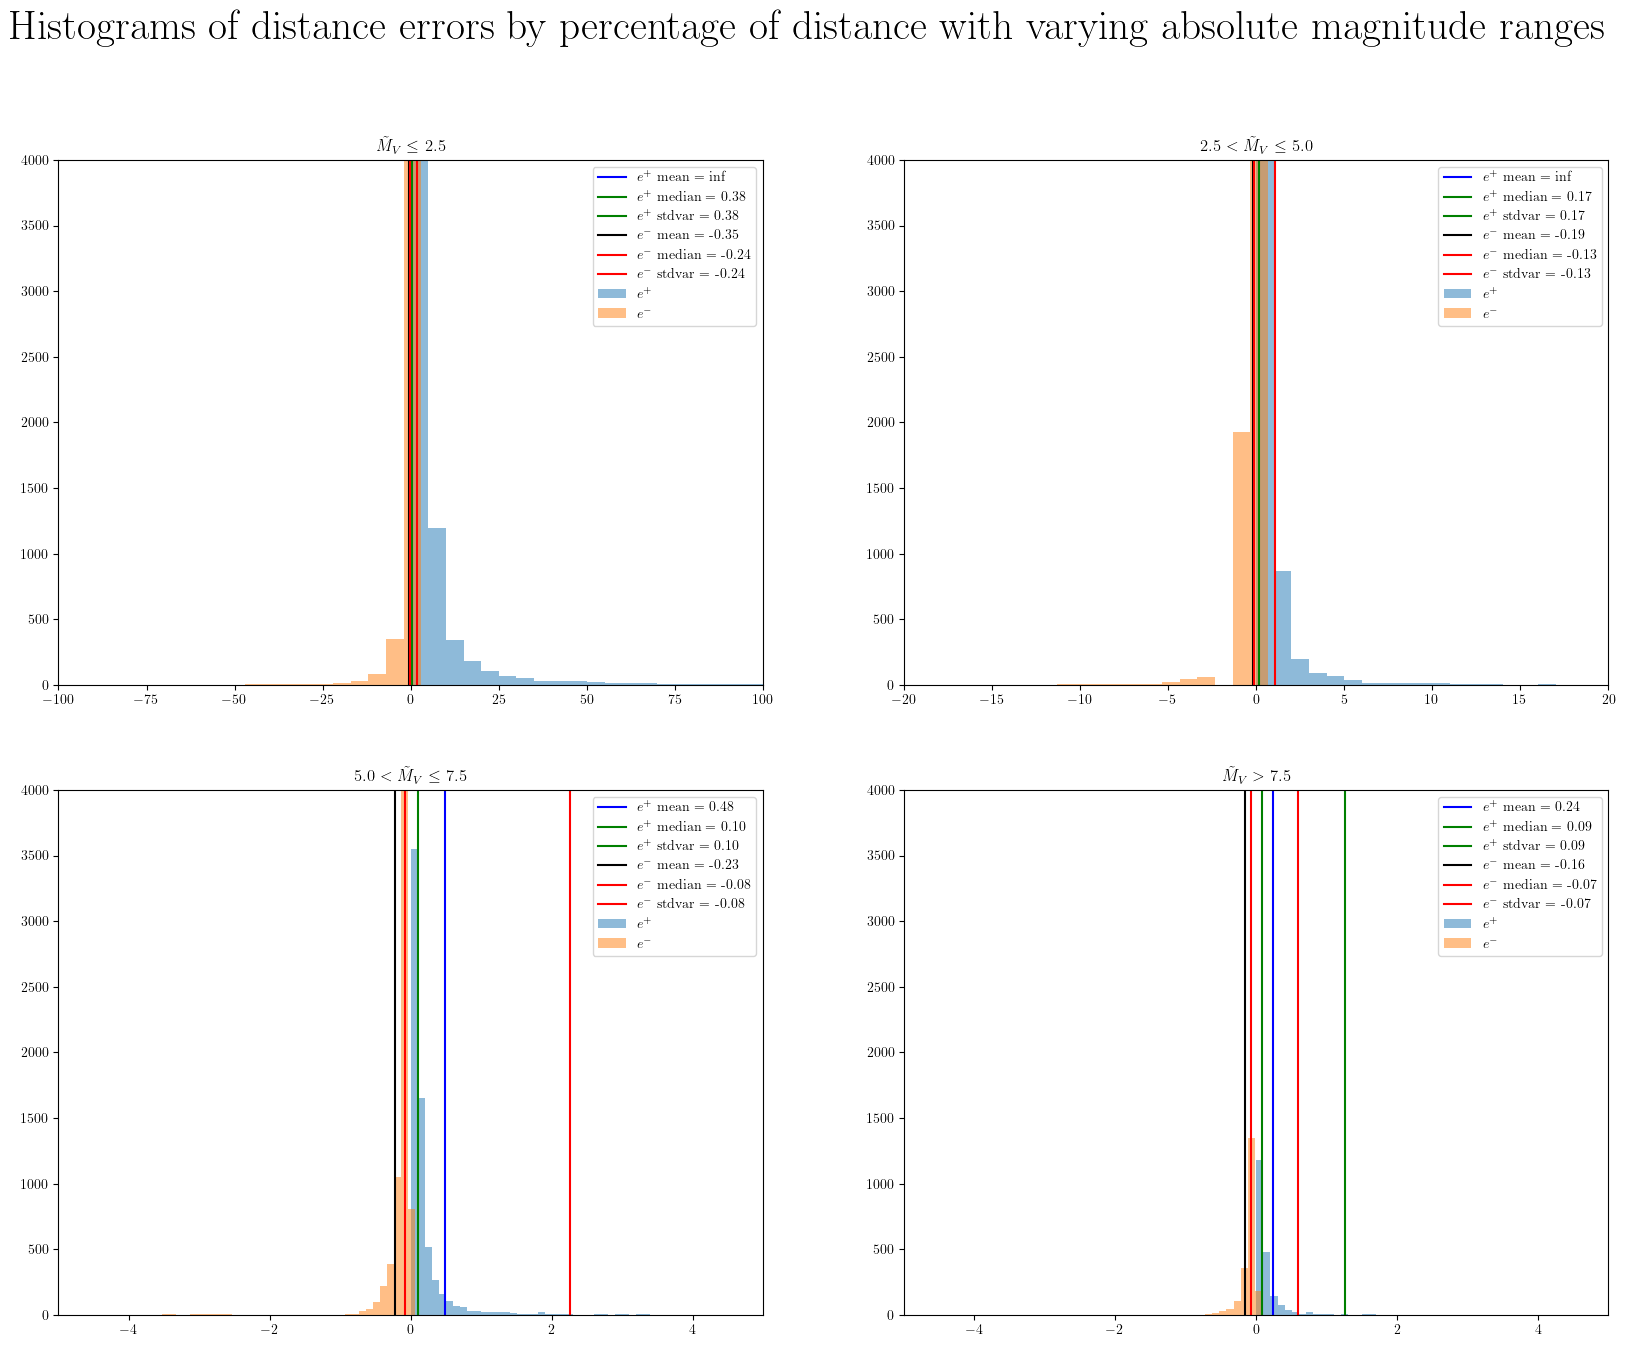

In [213]:
fig,ax = plt.subplots(2,2, figsize=(20,15))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
fig.suptitle("Histograms of distance errors by percentage of distance with varying absolute magnitude ranges", fontsize = 30)



hist_min, hist_max = (0,20)
hist_aspect = 0.1


quads = [2.5,5,7.5]
ax1_data = data[data["absmag"]<=quads[0]][data["Dist"]<4000].copy(deep=True)
ax1_data["e_Dist_pos_ratio"] = ax1_data["e_Dist_pos"]/ax1_data["Dist"]
ax1_data["e_Dist_neg_ratio"] = ax1_data["e_Dist_neg"]/ax1_data["Dist"]
ax1_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])
build_hists(ax1, ax1_data[ax1_data["e_Dist_pos"] > 0], "e_Dist_pos_ratio", ax1_title,r"$e^+$",["blue", "green"],5)
build_hists(ax1, ax1_data[ax1_data["e_Dist_neg"] < 0], "e_Dist_neg_ratio",ax1_title, r"$e^-$", ["black", "red"],5)
ax1.set_ylim(bottom = 0, top = 4000)
ax1.set_xlim(left = -100, right = 100)
ax1.legend()

ax2_data = data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]].copy(deep=True)
ax2_data["e_Dist_pos_ratio"] = ax2_data["e_Dist_pos"]/ax2_data["Dist"]
ax2_data["e_Dist_neg_ratio"] = ax2_data["e_Dist_neg"]/ax2_data["Dist"]
ax2_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1])
build_hists(ax2, ax2_data[ax2_data["e_Dist_pos"] > 0], "e_Dist_pos_ratio", ax2_title,r"$e^+$",["blue", "green"],1)
build_hists(ax2, ax2_data[ax2_data["e_Dist_neg"] < 0], "e_Dist_neg_ratio",ax2_title, r"$e^-$", ["black", "red"],1)
ax2.set_ylim(bottom = 0, top = 4000)
ax2.set_xlim(left = -20, right = 20)
ax2.legend()

# #plot_dist(ax2, h2[0], mean(ax2_data["Dist"]), variance(ax2_data["Dist"]))

ax3_data = data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]].copy(deep=True)
ax3_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2])
ax3_data["e_Dist_pos_ratio"] = ax3_data["e_Dist_pos"]/ax3_data["Dist"]
ax3_data["e_Dist_neg_ratio"] = ax3_data["e_Dist_neg"]/ax3_data["Dist"]
build_hists(ax3, ax3_data[ax3_data["e_Dist_pos"] > 0], "e_Dist_pos_ratio", ax3_title,r"$e^+$",["blue", "green"], .1)
build_hists(ax3, ax3_data[ax3_data["e_Dist_neg"] < 0], "e_Dist_neg_ratio",ax3_title, r"$e^-$", ["black", "red"], .1)
ax3.set_ylim(bottom = 0, top = 4000)
ax3.set_xlim(left = -5, right = 5)
ax3.legend()

ax4_data = data[data["absmag"]>quads[2]].copy(deep=True)
ax4_title = r"$\tilde{M}_V >$ %.1f"%(quads[2])
ax4_data["e_Dist_pos_ratio"] = ax4_data["e_Dist_pos"]/ax4_data["Dist"]
ax4_data["e_Dist_neg_ratio"] = ax4_data["e_Dist_neg"]/ax4_data["Dist"]
build_hists(ax4, ax4_data[ax4_data["e_Dist_pos"] > 0], "e_Dist_pos_ratio", ax4_title,r"$e^+$",["blue", "green"], .1)
build_hists(ax4, ax4_data[ax4_data["e_Dist_neg"] < 0], "e_Dist_neg_ratio",ax4_title, r"$e^-$", ["black", "red"], .1)
ax4.set_ylim(bottom = 0, top = 4000)
ax4.set_xlim(left = -5, right = 5)
ax4.legend()

# plt.savefig("Completeness/figures/dist_hist.png")
# plt.show()
# ax1.hist(data[data["absmag"]<=quads[0]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax1_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])

# ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax2_title = r"$\tilde{M}_V \le$ %.1f"%(quads[0])
# ax2.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1]))
# ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax3_title = r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2])
# ax3.set_title()
# ax4.hist(data[data["absmag"]>quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
# ax4_title = r"$\tilde{M}_V >$ %.1f"%(quads[2])
plt.savefig("Completeness/figures/e_Dist_perc_hist.png")
plt.show()

In [ ]:
rms = lambda data : np.sqrt(mean(data**2))


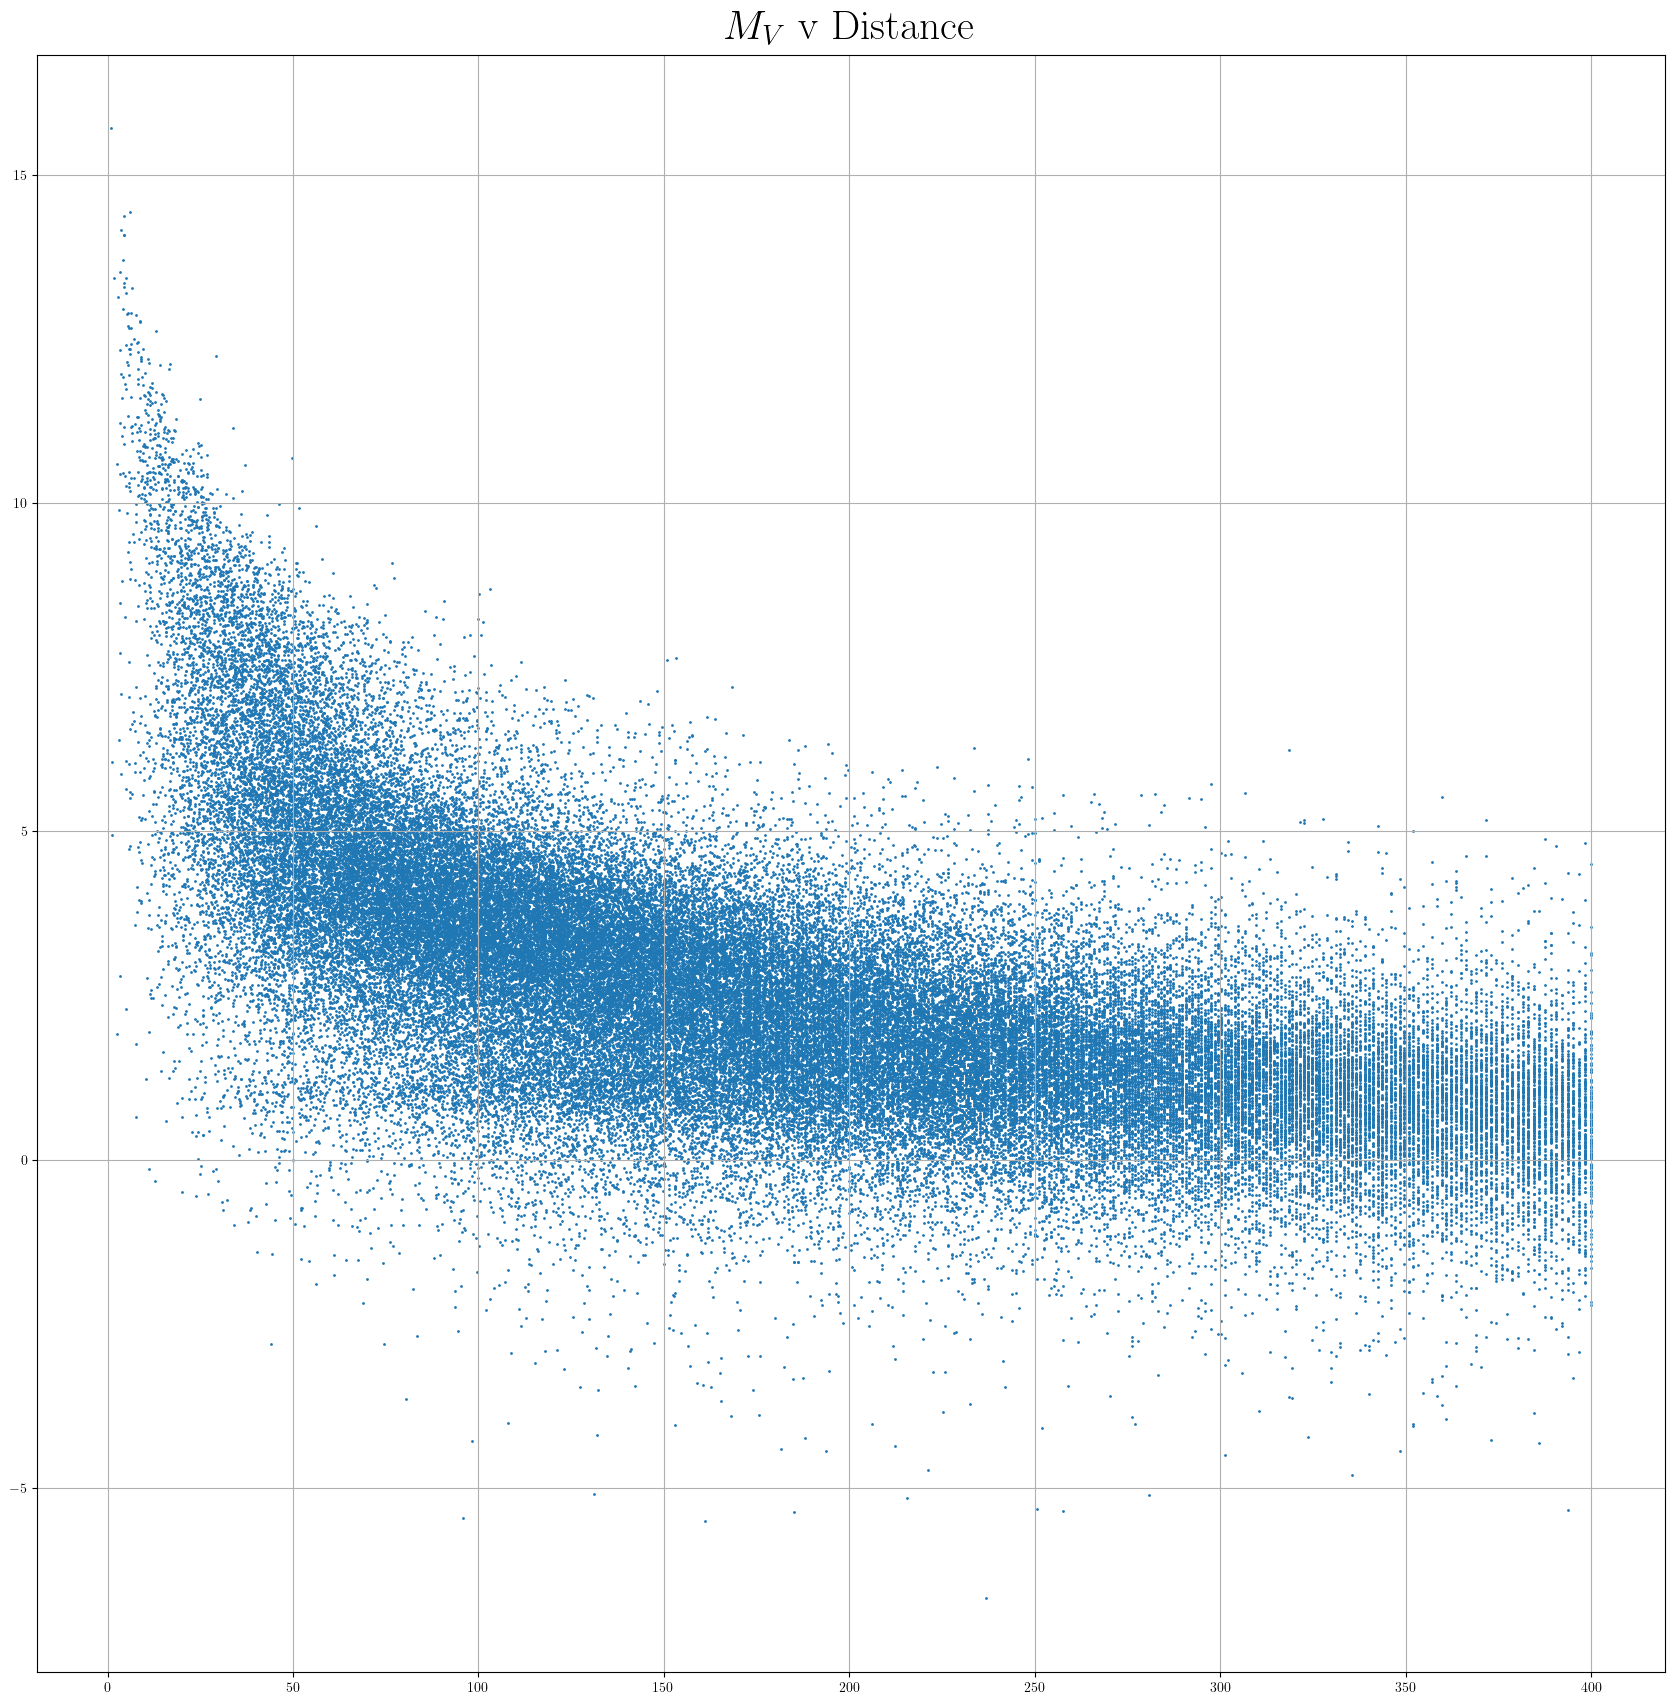

In [166]:
fig, ax = plt.subplots(1,1, figsize=(21,21))

r = np.ones(1000)*50
theta = np.linspace(0,2 * np.pi * 50,1000)

max_dist = 400

ax.scatter(data[data["Dist"]< max_dist]["Dist"], data[data["Dist"]< max_dist]["absmag"], s=1)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title(r"$M_V$ v Distance", va='bottom', fontsize = 30)
# ax.set_facecolor('black')
plt.savefig("Completeness/figures/dist_mag.png")
plt.show()

In [17]:
sol_mag = 4.83
sol_lum

NameError: name 'sol_lum' is not defined

# Statistics to do:
- list different star parameters (we have them in the Vizier/Readme.txt, go through and understand them all)
- use statistical methods to quantify how strongly different parameters correlate with one another
- divide up stars by longitudinal quadrants and compare the contents of each quadrant. How do the populations compare? Perform t-test (generate hypothesis)
- obvious selection bias for stars closer to us - compare how population changes with distance from Sol